In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataFields import DataFields
from DataFields import DateReportedFields
from ProjectFunctions import get_columns_from_chunk
from ProjectFunctions import convert_date_to_binary
from ProjectFunctions import count_na_in_dataframe
from ProjectFunctions import count_na_and_negative
from ProjectFunctions import one_hot_encode_vascular_problems

In [2]:
diagnosed_df = pd.read_csv("diagnosed.csv")

# Some fields report diagnosis by assigning the diagnosis date, while NA implies undiagnosed.
# convert features specified in "DateRportedFields" from date values, to binary
# meaning: NA = 0, Any date in range (see function) as 1
diagnosed_df = convert_date_to_binary(diagnosed_df, DateReportedFields)

# Count number of NA values per feature.
count_na_in_dataframe(diagnosed_df)

Lipoprotein A: 615 missing values
Direct bilirubin: 459 missing values
Testosterone: 402 missing values
SHBG: 371 missing values
Apolipoprotein A: 367 missing values
Calcium: 357 missing values
Glucose: 356 missing values
Phosphate: 355 missing values
HDL cholesterol: 354 missing values
Albumin: 354 missing values
Total protein: 354 missing values
Vitamin D: 303 missing values
Apolipoprotein B: 213 missing values
IGF-1: 210 missing values
C-reactive protein: 210 missing values
Urate: 208 missing values
Total bilirubin: 207 missing values
Aspartate aminotransferase: 206 missing values
LDL direct: 205 missing values
Pulse Rate at Blood Pressure: 203 missing values
Blood Pressure Diastolic: 203 missing values
Blood Pressure Systolic: 203 missing values
Urea: 202 missing values
Cholesterol: 202 missing values
Creatinine: 201 missing values
Triglycerides: 201 missing values
Gamma glutamyltransferase: 201 missing values
Cystatin C: 200 missing values
Alanine aminotransferase: 200 missing val

#### The following fields were removed due to significant count of NA values:
* Oestradiol
* Rheumatoid factor
* Recent trouble concentrating on things
* Bipolar or Major Depression
* Ever had prolonged feelings of sadness or depression

#### Map education and vascular problems

In [3]:
from ProjectFunctions import map_education_levels, map_vascular_levels

# map education in increasing hierarchy
diagnosed_df = map_education_levels(diagnosed_df)

# map vascular problems to meaningful values
diagnosed_df["Report of vascular problems"] = diagnosed_df["Report of vascular problems"].replace({-7: 0, -3: pd.NA})

diagnosed_df.to_csv("diagnosed_processed.csv", index=False)

#### Histogram of patients by NA values

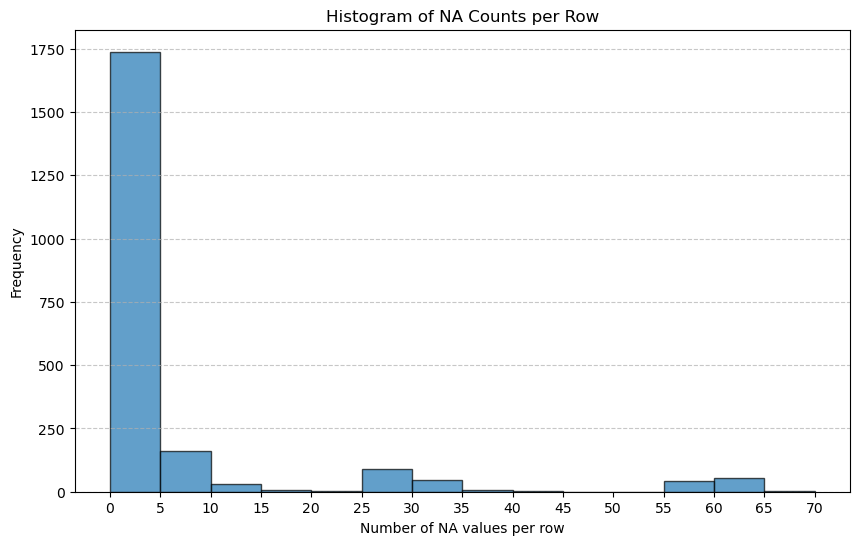

In [4]:
import matplotlib.pyplot as plt

# plot a histogram out of patients to see how many patients miss a lot of data, and which not much.
def plot_na_histogram(df):
    na_counts = df.isna().sum(axis=1)  # Count NA values per row
    
    bin_size = 5
    max_na = na_counts.max()
    bins = list(range(0, max_na + bin_size, bin_size))
    
    plt.figure(figsize=(10, 6))
    plt.hist(na_counts, bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel('Number of NA values per row')
    plt.ylabel('Frequency')
    plt.title('Histogram of NA Counts per Row')
    plt.xticks(bins)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

df = pd.read_csv("diagnosed_processed.csv")

plot_na_histogram(df)

#### Remove patients with too many NA values (more than 20)

In [5]:
from ProjectFunctions import drop_rows_with_na_greater_than

df = pd.read_csv("diagnosed_processed.csv")

df = df.drop(columns=["id"])

df = df.mask(df < 0) # convert all columns less than 0 to NA

df = drop_rows_with_na_greater_than(df, 20)

df.describe()


,Birth Year,Sex,Education,Primary Hypertension,Secondary Hypertension,BMI Impedance,Smoking Status,Ever Smoked,Alcohol Intake Frequency,Report of stroke,...,Platelet distribution width,Red blood cell (erythrocyte) count,Red blood cell (erythrocyte) distribution width,Reticulocyte count,Reticulocyte percentage,White blood cell (leukocyte) count,Blood Pressure Diastolic,Blood Pressure Systolic,Pulse Rate at Blood Pressure,Has Vascular Dementia
count,1939.000000,1939.000000,1891.000000,1939.000000,1939.000000,1928.000000,1918.000000,1918.000000,1933.000000,1939.000000,...,1939.000000,1939.000000,1939.000000,1910.000000,1910.000000,1939.000000,1786.000000,1786.000000,1786.000000,1939.0
mean,1943.169159,0.591542,1.199894,0.789067,0.003094,28.527425,0.701251,0.672054,3.186239,0.311501,...,16.539562,4.488396,13.727148,0.064506,1.440696,7.347432,82.035834,147.092945,70.844905,1.0
std,4.233419,0.491675,1.134463,0.408076,0.055555,5.084985,0.679001,0.469587,1.705088,0.463226,...,0.534139,0.441748,1.098247,0.035772,0.816285,1.967500,11.108977,20.893281,13.183940,0.0
min,1937.000000,0.000000,0.000000,0.000000,0.000000,15.757600,0.000000,0.000000,1.000000,0.000000,...,15.200000,1.720000,11.490000,0.012000,0.263000,2.370000,47.000000,78.000000,35.000000,1.0
25%,1940.000000,0.000000,0.000000,1.000000,0.000000,25.055875,0.000000,0.000000,2.000000,0.000000,...,16.200000,4.200000,13.100000,0.045000,1.021250,6.040000,74.250000,132.000000,62.000000,1.0
50%,1942.000000,1.000000,1.000000,1.000000,0.000000,27.771700,1.000000,1.000000,3.000000,0.000000,...,16.500000,4.483000,13.530000,0.060000,1.332000,7.120000,82.000000,146.000000,70.000000,1.0
75%,1945.000000,1.000000,2.000000,1.000000,0.000000,31.367300,1.000000,1.000000,5.000000,1.000000,...,16.860000,4.769500,14.100000,0.078000,1.740000,8.440000,89.000000,160.000000,79.000000,1.0
max,1965.000000,1.000000,3.000000,1.000000,1.000000,54.528300,2.000000,1.000000,6.000000,1.000000,...,19.400000,6.390000,31.700000,1.077000,25.278000,34.130000,132.000000,241.000000,169.000000,1.0


In [6]:
df.to_csv("diagnosed_processed.csv", index=False)

#### Estimate new values for missing columns using Iterative Imputer

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import time

In [9]:
df = pd.read_csv("diagnosed_processed.csv")

imputer = IterativeImputer(max_iter=50)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

df_imputed.to_csv("diagnosed_imputed.csv", index=False)
df_imputed.describe()

,Birth Year,Sex,Education,Primary Hypertension,Secondary Hypertension,BMI Impedance,Smoking Status,Ever Smoked,Alcohol Intake Frequency,Report of stroke,...,Platelet distribution width,Red blood cell (erythrocyte) count,Red blood cell (erythrocyte) distribution width,Reticulocyte count,Reticulocyte percentage,White blood cell (leukocyte) count,Blood Pressure Diastolic,Blood Pressure Systolic,Pulse Rate at Blood Pressure,Has Vascular Dementia
count,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,...,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.0
mean,1943.169159,0.591542,1.199414,0.789067,0.003094,28.538077,0.701358,0.671976,3.186321,0.311501,...,16.539562,4.488396,13.727148,0.064510,1.440701,7.347432,82.058782,147.154018,70.936634,1.0
std,4.233419,0.491675,1.120726,0.408076,0.055555,5.074558,0.676035,0.467371,1.702673,0.463226,...,0.534139,0.441748,1.098247,0.035507,0.810155,1.967500,10.738214,20.127627,12.748632,0.0
min,1937.000000,0.000000,0.000000,0.000000,0.000000,15.757600,-0.106493,0.000000,1.000000,0.000000,...,15.200000,1.720000,11.490000,0.012000,0.263000,2.370000,47.000000,78.000000,35.000000,1.0
25%,1940.000000,0.000000,0.000000,1.000000,0.000000,25.070900,0.000000,0.000000,2.000000,0.000000,...,16.200000,4.200000,13.100000,0.046000,1.028000,6.040000,75.000000,133.078514,62.346120,1.0
50%,1942.000000,1.000000,1.000000,1.000000,0.000000,27.805800,1.000000,1.000000,3.000000,0.000000,...,16.500000,4.483000,13.530000,0.061000,1.340000,7.120000,82.000000,146.559716,70.000000,1.0
75%,1945.000000,1.000000,2.000000,1.000000,0.000000,31.385650,1.000000,1.000000,5.000000,1.000000,...,16.860000,4.769500,14.100000,0.078000,1.739000,8.440000,88.497822,159.000000,78.000000,1.0
max,1965.000000,1.000000,3.000000,1.000000,1.000000,54.528300,2.000000,1.000000,6.000000,1.000000,...,19.400000,6.390000,31.700000,1.077000,25.278000,34.130000,132.000000,241.000000,169.000000,1.0
